In [1]:
import os
import urllib.request
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision.models.detection import ssd
from torchvision.models.detection.ssd import SSDClassificationHead

In [2]:
# ***************** Declaring Paths *****************
MOBILENET_PATH = r"C:\\Users\\Yasir\\Desktop\\Internship\\Object_Detection_video\\CNN_MobileNet_SSD"
YOLOV3_PATH = r"C:\\Users\\Yasir\\Desktop\\Internship\\Object_Detection_video\\CNN_YOLOV3"
STREETS_DATASET_PATH = r"C:\\Users\\Yasir\\Desktop\\Internship\\Object_Detection_video\\streets_dataset"

TRAIN_IMAGES_DIR = os.path.join(STREETS_DATASET_PATH, "train", "images")
TRAIN_LABELS_DIR = os.path.join(STREETS_DATASET_PATH, "train", "labels")

VAL_IMAGES_DIR = os.path.join(STREETS_DATASET_PATH, "valid", "images")
VAL_LABELS_DIR = os.path.join(STREETS_DATASET_PATH, "valid", "labels")

TEST_IMAGES_DIR = os.path.join(STREETS_DATASET_PATH, "test", "images")
TEST_LABELS_DIR = os.path.join(STREETS_DATASET_PATH, "test", "labels")

os.makedirs(MOBILENET_PATH, exist_ok=True)
os.makedirs(YOLOV3_PATH, exist_ok=True)

In [3]:
# ****************** MODEL DOWNLOAD SECTION ******************
mobilenet_files = {
    'deploy.prototxt': {
        'url': 'https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/deploy.prototxt',
        'path': os.path.join(MOBILENET_PATH, 'deploy.prototxt')
    },
    'mobilenet_iter_73000.caffemodel': {
        'url': 'https://github.com/chuanqi305/MobileNet-SSD/raw/master/mobilenet_iter_73000.caffemodel',
        'path': os.path.join(MOBILENET_PATH, 'mobilenet_iter_73000.caffemodel')
    }
}

yolo_files = {
    'yolov3.weights': {
        'url': 'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights',
        'path': os.path.join(YOLOV3_PATH, 'yolov3.weights')
    },
    'yolov3.cfg': {
        'url': 'https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov3.cfg',
        'path': os.path.join(YOLOV3_PATH, 'yolov3.cfg')
    },
    'coco.names': {
        'url': 'https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names',
        'path': os.path.join(YOLOV3_PATH, 'coco.names')
    }
}

print("Downloading model files if needed...")
for model_files in [mobilenet_files, yolo_files]:
    for file_name, file_info in model_files.items():
        if not os.path.exists(file_info['path']):
            print(f"Downloading {file_name} from {file_info['url']}...")
            try:
                opener = urllib.request.build_opener()
                opener.addheaders = [('User-agent', 'Mozilla/5.0')]
                urllib.request.install_opener(opener)

                def report_progress(count, block_size, total_size):
                    percent = int(count * block_size * 100 / total_size)
                    print(f"\rProgress: {percent}%", end='')

                urllib.request.urlretrieve(
                    file_info['url'],
                    file_info['path'],
                    reporthook=report_progress if file_name == 'yolov3.weights' else None
                )
                print(f"\nSuccessfully downloaded {file_name} to {file_info['path']}")
            except Exception as e:
                print(f"\nError downloading {file_name}: {e}")
                continue

required_files = [
    mobilenet_files['deploy.prototxt']['path'],
    mobilenet_files['mobilenet_iter_73000.caffemodel']['path'],
    yolo_files['yolov3.weights']['path'],
    yolo_files['yolov3.cfg']['path'],
    yolo_files['coco.names']['path']
]

missing_files = [f for f in required_files if not os.path.exists(f)]
if missing_files:
    print("\nWarning: Some model files are missing:")
    for f in missing_files:
        print(f"- {f}")
else:
    print("\nAll model files are ready!")



All model files are ready!


In [4]:
# ****************** MODEL INITIALIZATION SECTION ******************
print("Loading MobileNet SSD model...")
mobilenet_net = cv2.dnn.readNetFromCaffe(
    mobilenet_files['deploy.prototxt']['path'],
    mobilenet_files['mobilenet_iter_73000.caffemodel']['path']
)
mobilenet_classes = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair",
                     "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train",
                     "tvmonitor"]
mobilenet_colors = np.random.uniform(0, 255, size=(len(mobilenet_classes), 3))

print("Loading YOLOv3 model...")
yolo_net = cv2.dnn.readNet(
    yolo_files['yolov3.weights']['path'],
    yolo_files['yolov3.cfg']['path']
)
yolo_layer_names = yolo_net.getLayerNames()
yolo_output_layers = [yolo_layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]
with open(yolo_files['coco.names']['path'], "r") as f:
    yolo_classes = [line.strip() for line in f.readlines()]
yolo_colors = np.random.uniform(0, 255, size=(len(yolo_classes), 3))


Loading MobileNet SSD model...
Loading YOLOv3 model...


In [5]:
# ****************** UI SECTION ******************
stop_button = widgets.ToggleButton(value=False, description='Stop Detection', button_style='danger')
accuracy_button = widgets.Button(description='Show Accuracy', button_style='success')
display(widgets.HBox([stop_button, accuracy_button]))

model_accuracies = {'MobileNet SSD': [], 'YOLOv3': []}

In [6]:
# ****************** DETECTION FUNCTIONS ******************
def mobilenet_detect(frame):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)
    mobilenet_net.setInput(blob)
    detections = mobilenet_net.forward()
    confidences = []
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            confidences.append(confidence)
            idx = int(detections[0, 0, i, 1])
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            label = f"{mobilenet_classes[idx]}: {confidence:.2f}%"
            cv2.rectangle(frame, (startX, startY), (endX, endY), mobilenet_colors[idx], 2)
            y = startY - 15 if startY - 15 > 15 else startY + 15
            cv2.putText(frame, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, mobilenet_colors[idx], 2)
    if confidences:
        model_accuracies['MobileNet SSD'].append(np.mean(confidences))
    return frame

def yolo_detect(frame):
    height, width = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    yolo_net.setInput(blob)
    outs = yolo_net.forward(yolo_output_layers)
    conf_threshold = 0.5
    nms_threshold = 0.4
    boxes, confidences, class_ids = [], [], []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x, center_y = int(detection[0]*width), int(detection[1]*height)
                w, h = int(detection[2]*width), int(detection[3]*height)
                x, y = int(center_x - w/2), int(center_y - h/2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    for i in indices:
        i = i[0] if isinstance(i, (tuple, list, np.ndarray)) else i
        x, y, w, h = boxes[i]
        label = f"{yolo_classes[class_ids[i]]}: {confidences[i]:.2f}"
        color = yolo_colors[class_ids[i]]
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    if confidences:
        model_accuracies['YOLOv3'].append(np.mean(confidences))
    return frame

def show_accuracy(b):
    plt.figure(figsize=(10, 5))
    for model, acc in model_accuracies.items():
        if acc:
            plt.plot(acc, label=f"{model} (Avg: {np.mean(acc):.2f})")
    plt.title('Model Detection Confidence Over Time')
    plt.ylabel('Confidence')
    plt.xlabel('Frame')
    plt.legend()
    plt.show()

accuracy_button.on_click(show_accuracy)

def detect_image(image_path, model_choice):
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: Could not read image from {image_path}")
        return
    
    frame = mobilenet_detect(frame) if model_choice == 'MobileNet SSD' else yolo_detect(frame)
    cv2.putText(frame, f"Model: {model_choice}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    # Convert from BGR to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    _, ret = cv2.imencode('.jpg', frame_rgb)
    display(Image(data=ret))

def select_and_detect_image():
    print("\nAvailable image directories:")
    print("1. Train images")
    print("2. Validation images")
    print("3. Test images")
    
    dir_choice = input("Select directory (1-3): ").strip()
    if dir_choice == '1':
        image_dir = TRAIN_IMAGES_DIR
    elif dir_choice == '2':
        image_dir = VAL_IMAGES_DIR
    elif dir_choice == '3':
        image_dir = TEST_IMAGES_DIR
    else:
        print("Invalid choice. Using test images by default.")
        image_dir = TEST_IMAGES_DIR
    
    # List available images
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f"No images found in {image_dir}")
        return
    
    print("\nAvailable images:")
    for i, img in enumerate(image_files[:10]):  # Show first 10 to avoid too much output
        print(f"{i+1}. {img}")
    print("... (showing first 10 images)" if len(image_files) > 10 else "")
    
    img_choice = input("Enter image number or name: ").strip()
    try:
        # Try to interpret as number
        img_idx = int(img_choice) - 1
        if 0 <= img_idx < len(image_files):
            selected_image = image_files[img_idx]
        else:
            print("Invalid number. Using first image.")
            selected_image = image_files[0]
    except ValueError:
        # Interpret as filename
        if img_choice in image_files:
            selected_image = img_choice
        else:
            print("Image not found. Using first image.")
            selected_image = image_files[0]
    
    image_path = os.path.join(image_dir, selected_image)
    print(f"\nSelected image: {image_path}")
    
    model_choice = input("Through which model do you want to scan this picture?\nPress A for MobileNet SSD or B for YOLOv3: ").strip().upper()
    if model_choice == 'A':
        detect_image(image_path, 'MobileNet SSD')
    elif model_choice == 'B':
        detect_image(image_path, 'YOLOv3')
    else:
        print("Invalid model selection. Using MobileNet SSD by default.")
        detect_image(image_path, 'MobileNet SSD')


In [7]:
# ****************** MAIN DETECTION LOOP ******************
def detect_objects(model_choice):
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    while True:
        if stop_button.value:
            stop_button.description = 'Stopped'
            cap.release()
            cv2.destroyAllWindows()
            break
        ret, frame = cap.read()
        if not ret:
            break
        frame = mobilenet_detect(frame) if model_choice == 'MobileNet SSD' else yolo_detect(frame)
        cv2.putText(frame, f"Model: {model_choice}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        _, ret = cv2.imencode('.jpg', frame)
        display(Image(data=ret))
        clear_output(wait=True)
        time.sleep(0.05)


Do you want to start the detection? (y/n):  y
Which model do you want to use?
Press A for MobileNet SSD, B for YOLOv3, or C to select an image from dataset:  C



Available image directories:
1. Train images
2. Validation images
3. Test images


Select directory (1-3):  1



Available images:
1. aguanambi-1000_png_jpg.rf.0ab6f274892b9b370e6441886b2d7b9d.jpg
2. aguanambi-1000_png_jpg.rf.dc59d3c5df5d991c1475e5957ea9948c.jpg
3. aguanambi-1000_png_jpg.rf.f425c626b206bb27a1b73fa7e38d6361.jpg
4. aguanambi-1085_png_jpg.rf.60d1095729839f1644f21e2a31e55cec.jpg
5. aguanambi-1085_png_jpg.rf.9560a8e9822039cd2b4566dd71f288a7.jpg
6. aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.jpg
7. aguanambi-1090_png_jpg.rf.6bc72d297979796c1a87ba754fec824c.jpg
8. aguanambi-1090_png_jpg.rf.906544c343fd56ec0ed1ed1f48e8e7c2.jpg
9. aguanambi-1090_png_jpg.rf.da8757883707a0aba29fb71deb2f8872.jpg
10. aguanambi-1100_png_jpg.rf.09650bd053f33e6057e6e1840ca909f9.jpg
... (showing first 10 images)


Enter image number or name:  1



Selected image: C:\\Users\\Yasir\\Desktop\\Internship\\Object_Detection_video\\streets_dataset\train\images\aguanambi-1000_png_jpg.rf.0ab6f274892b9b370e6441886b2d7b9d.jpg


Through which model do you want to scan this picture?
Press A for MobileNet SSD or B for YOLOv3:  B


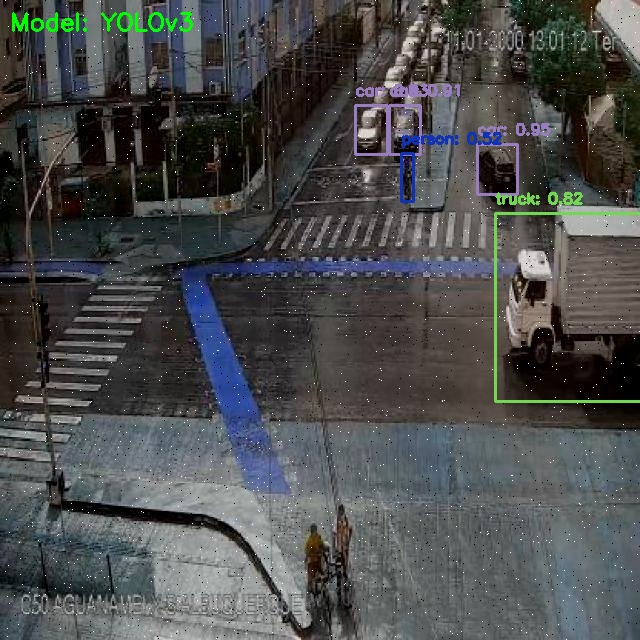

In [9]:
# ****************** USER PROMPT ******************
start_input = input("Do you want to start the detection? (y/n): ").strip().lower()
if start_input == 'y':
    model_input = input("Which model do you want to use?\nPress A for MobileNet SSD, B for YOLOv3, or C to select an image from dataset: ").strip().upper()
    if model_input == 'A':
        print("Starting detection with MobileNet SSD...")
        detect_objects('MobileNet SSD')
    elif model_input == 'B':
        print("Starting detection with YOLOv3...")
        detect_objects('YOLOv3')
    elif model_input == 'C':
        select_and_detect_image()
    else:
        print("Invalid model selection. Please press A, B, or C.")
elif start_input == 'n':
    cap = cv2.VideoCapture(0)
    if cap.isOpened():
        cap.release()
    cv2.destroyAllWindows()
    print("Detection aborted by user. Webcam closed, project ended.")
else:
    print("Invalid input. Please enter 'y' or 'n'.")